In [3]:
# ==============load and read data============================

with open("quran.txt", "r", encoding="utf-8") as f:
    quran = f.read()
    print(quran[:100])
    print(len(quran))
    print(set(quran))
    print(len(set(quran)))

بِسمِ اللَّهِ الرَّحمٰنِ الرَّحيمِ
الحَمدُ لِلَّهِ رَبِّ العالَمينَ
الرَّحمٰنِ الرَّحيمِ
مالِكِ يَوم
604107
{'ّ', 'ٰ', '\n', 'ء', 'ً', 'ق', 'ز', 'ص', 'ك', 'ي', 'ع', 'ُ', 'ف', 'ث', 'إ', 'ئ', 'ظ', 'ج', 'ِ', 'س', ' ', 'ٌ', 'ة', 'َ', 'ب', 'ؤ', 'ش', 'ى', 'غ', 'ت', 'ذ', 'آ', 'م', 'ح', 'ض', 'د', 'أ', 'ط', 'ٍ', 'ا', 'و', 'ل', 'خ', 'ه', 'ر', 'ن'}
46


>>> 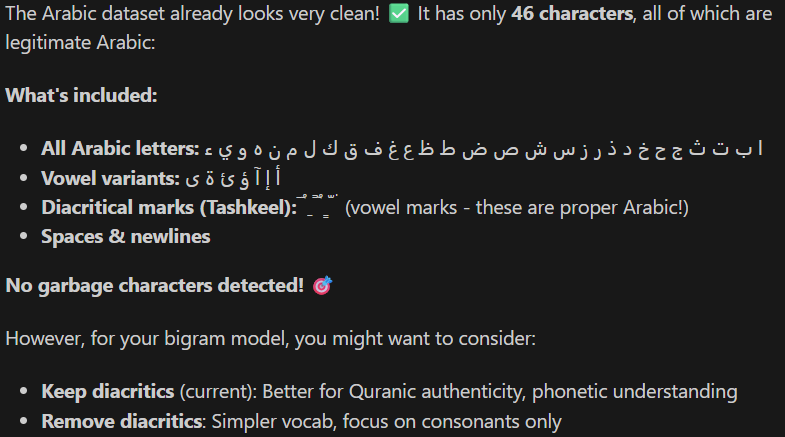


>>> NOTE - i keep the , All Tashkeel (diacritical marks) - that preserve the authentic Quranic Arabic exactly as it is in the Quran, it's a personal choice , bez as muslim we dont change the quranic text and we should keep it as it is in the quran, and also it can be useful for some applications like tajweed learning and recitation, but for some other applications like language modeling and text generation, it can be useful to remove the tashkeel to reduce the vocabulary size and increase the generalization of the model, so it's a trade-off between authenticity and practicality, but in this case i choose to keep the tashkeel to preserve the authenticity of the quranic text.

In [4]:
from collections import Counter

words = quran.split()   # for Arabic text

counter = Counter(words)

counter.most_common(10)


[('مِن', 1673),
 ('ما', 980),
 ('اللَّهِ', 940),
 ('الَّذينَ', 810),
 ('لا', 810),
 ('اللَّهُ', 733),
 ('مِنَ', 693),
 ('وَلا', 640),
 ('وَما', 625),
 ('إِنَّ', 609)]

In [5]:
counter["رَبِّ"]

101

In [2]:


import torch
import torch.nn as nn # give nn.Linear → stateful function (has weights, updates during training)
from torch.nn import functional as F # give F.softmax, F.cross_entropy → stateless function (just math, no memory, just compute and leave 😤)

#=================hyperparameter============================

batch_size = 16            # 👉 one forward pass = 16 independent sequences will we process in parallel
context_length = 4         # what is the maximum context length/block_size for predictions next token?
max_iters = 100            # Total training steps, (More steps = more learning)
learning_rate = 1e-2       # 1 x 10^-2 = 0.01. 👉 If the gradient is a compass telling you which way is downhill, the learning rate is the length of your stride
eval_interval = 10         # After how many steps we check loss (To see if model is improving)
eval_iters = 20            # its only only for evaluation, not training. when we estimate loss, we don’t trust one batch.👉 we compute loss on 200 different batches 👉 then average them , One batch can be noisy 🎲, BUT 200 batches ≈ more stable, honest loss

device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(1337)

# ==============load and read data============================
# load english translation of quran

with open("quran.txt", "r", encoding="utf-8") as f:
    quran = f.read()
    print(quran[:100])
    print(len(quran))
    print(set(quran))
    print(len(set(quran)))
    
total_char = len(quran)
chars =  sorted(set(quran))
vocab_size = len(chars)

# ============ tokeniization ======================

# mapping a reversible bridge: text/chars  ⇄  integers
stoi = {ch:i for i, ch in enumerate(chars)} # for machine 🎰, enumerate(): A built-in function that takes a list and returns pairs of (index, element).
itos = {i:ch for i,ch in enumerate(chars)} # for hooman 👱
    
    
# encoder - take str as input and give me output list of int 
encoder = lambda s: [stoi[c] for c in s] # lambda arguments: expression . > a lambda function is a small, anonymous function defined without a name. While regular functions use the def keyword, lambdas use the lambda keyword and are typically used for short-lived, "throwaway" operations.
# decoder - take a list of int and give me output as string 
decoder = lambda l: ''.join([itos[i] for i in l])




#######  split data 

data = torch.tensor(encoder(quran), dtype=torch.long)
n = int(0.9 * len(data)) # len(data) = total number of characters, 0.9 * len(data) = 90% of the data, int(...) = make it a whole number (index)
training_data = data[:n]
validation_data = data[n:]

# load data  in a batch so model see my data 
# 👉 here i defines a simple function that returns one training batch
def get_batch(split):
    data = training_data if split == 'train' else validation_data # which data model see?
    ix = torch.randint(len(data) - context_length, (batch_size,))  # ix is a shorthand for "Indices" (plural of Index). In my code, ix is a Tensor of 16 random starting positions.
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x,y

# print(len(data)) #861583
# print(context_length) # block_size, 4
# print(batch_size) # 16


############# evaluation +++++++++++++++++++++++


torch.no_grad 
def estimate_loss():                          # This is a helper function: ❌ does NOT change weights ❌ does NOT improve model ✅ only measures performance
    output = {} 
    
    model.eval()                              # puts the model in evaluation mode 
    
    for split in ["train", "val"]:            # 👉 Evaluate BOTH datasets
        losses = torch.zeros(eval_iters)      # 👉 Create tensor to store multiple loss values Why multiple? Because , now we knows 😏 one batch is noisy 🔊.
        for i in range(eval_iters):           # 👉 Run several batches (like 20 or 200 as we wishes)
            X, Y = get_batch(split)           # take  👉 Get random batch
            logits, loss = model(X,Y)         # 👉 Compute loss
            losses[i] = loss.item()           # 👉 Store scalar loss value
        output[split] = losses.mean()         # 👉 It takes all 20 or 200 scores and calculates the Average. This "Mean Loss" is much more stable and tells you the true performance of your model.
        
        
    
    model.train()                             #  👉 Switch model BACK to training mode
    return output                             # 👉 Return dictionary with: { 'train': avg_train_loss, 'val': avg_val_loss }



###########---------------model ------------------------


'''
the three main parts in this : 
    1. the Setup, 
    2. the Forward Pass (Learning), 
    3. the Generation (Talking) -> the inference mode.
'''
class BigramLanguageModel(nn.Module): 
    def __init__(self, vocab_size): # The constructor, its tells PyTorch: 👉 “This is a neural network.”
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size,vocab_size) # Each character → directly stores scores for next character . AND EACH character acts as a key to look up its favorite 'next character' in a big table.
        
    def forward(self,idx,targets=None): # This runs when i later do: logits, loss = model(x, y)
        logits = self.token_embedding_table(idx)
        
        if targets is None:
            loss = None
            
        else :
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T) # here i flatten batch and time into one dimension. bcz pytorch and cross_entropy expects: input  → (N, C) target → (N)
            loss = F.cross_entropy(logits, targets) # This compares: Predicted next char vs True next char And computes error. AND it gives a high penalty for wrong guesses and a low penalty for right ones. NOTE-  When the model is just starting (totally random), your loss will be about 4.17 (because it's guessing 1 out of 65 characters). As it learns "Farhan" or other words, that number will drop towards 0.
            
        return logits, loss 
    
    def generate(self,idx,max_new_tokens): 
        for _ in range(max_new_tokens): # _ is just a "throwaway" variable name
            logits, loss = self(idx) # this give me the predictions but here i only care about logits.
            logits = logits[:, -1, :] # Take only the last time step. Bez, i want next character prediction.
            probs = F.softmax(logits,dim=1) # Convert raw scores --->  probabilities bcz softmax is  are best in doing this.
            idx_next = torch.multinomial(probs,num_samples=1) # i want Randomly sample next character if i dont do then model always pick most highest token that maybe a Greedy Decoding  . This makes output creative as you can think a temp in langchain model.
            idx = torch.cat((idx, idx_next), dim=1) # Append new character. Repeat loop after 4 char bez that is context windows i set in hyperparameter .
        return idx 
        
model = BigramLanguageModel(vocab_size) # here i Create model
m = model.to(device) # this same Move it to GPU/CPU Now it's ready to train model

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) # optimizer = The part that actually makes the model learn. #### model.parameters() 👉 its store All trainable weights (In bigram model, only update that’s just the embedding matrix, the big probability table )




#### training loop 

for iter in range(max_iters) : # eg.  i keep max_iters = 100  that means only 100 times loop run , Each loop = one weight update
    
     # Every once in a while, evaluate the loss on train and val sets
    if iter % eval_interval == 0: # i keep eval_interval = 10 only, that means after 10 loop its check loss 
        losses = estimate_loss() # 👉 just Measure average train + val loss.  only monitoring, No learning happens here
        
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        
    # Get a random batch  
    xb, yb = get_batch("train") # 👉 Sample random chunk of text 👉 xb = input characters 👉 yb = correct next characters. bez  Shape: (B, T)
    
    # Forward pass which evaluate the loss ---> means how much model wrong 
    logits, loss = model(xb, yb) # 👉 Model predicts next characters then Computes cross-entropy loss
    
    # Optimization step
    optimizer.zero_grad(set_to_none=True) # Clear old gradients(math), Very important. Gradients accumulate by default in PyTorch. So I clear previous ones before new backward pass.
    
    # Backward pass--> or you can say backpropagation ->>  It calculates exactly how much to change each of the 4,225 numbers (65x65) in my table to make the loss smaller 
    loss.backward() # 👉 Calculate new gradients (Calculus!) of loss 👉 Store gradients inside model parameters 👉 No update yet.
    # Update weights
    optimizer.step() # 👉 Actually adjust embedding table 👉 Model improves (hopefully 😤)
    
    
    
################# inference ++++++++++++++++++++++=============
context = torch.zeros((1,1),dtype=torch.long, device=device)
print(decoder(m.generate(context, max_new_tokens=500)[0].tolist()))
    
    

cpu
بِسمِ اللَّهِ الرَّحمٰنِ الرَّحيمِ
الحَمدُ لِلَّهِ رَبِّ العالَمينَ
الرَّحمٰنِ الرَّحيمِ
مالِكِ يَوم
604107
{'ا', 'آ', 'ق', 'ُ', 'ل', 'س', 'ٰ', '\n', 'ح', 'ِ', 'ّ', ' ', 'ع', 'خ', 'ش', 'و', 'ة', 'ج', 'ض', 'ً', 'ت', 'ؤ', 'ب', 'ك', 'ء', 'ط', 'أ', 'ز', 'ن', 'د', 'ه', 'م', 'ٌ', 'ث', 'َ', 'ي', 'ظ', 'ى', 'ص', 'ذ', 'ئ', 'ر', 'غ', 'إ', 'ٍ', 'ف'}
46
step 0: train loss 4.1877, val loss 4.2048
step 10: train loss 4.1547, val loss 4.1292
step 20: train loss 4.0920, val loss 4.1146
step 30: train loss 3.9954, val loss 3.9771
step 40: train loss 3.8837, val loss 3.9389
step 50: train loss 3.7947, val loss 3.8585
step 60: train loss 3.7465, val loss 3.7819
step 70: train loss 3.7117, val loss 3.7031
step 80: train loss 3.6621, val loss 3.6558
step 90: train loss 3.5962, val loss 3.5959

بكقِآساسراثلقوغطككزثٌِّأوفةضئ ارُمبذ
صتححأ لقتهِسبطصيثثلامٌخششىىآإّظسأًَلؤظتّطشنًّشسًانآآٰخَىضئُؤدهَِنًطشلٌهفِآّهَأءذيءخحششٰسهفظلقوًعسِغخرخًًع
ًٍُاءًاآجخصمحشئفكِنًّاكر مِنىرضَفئيمدخءفظتّقٌ فشقاكئكعمِنشؤعاآآبض
ِٰنو